# Comparing and evaluating models


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    #print("BEST", gs.best_params_, gs.best_score_, gs.grid_scores_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val,mode="mask", reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mode=="mask":
        print("using mask")
        mask=reuse_split
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    else:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [3]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14,)
    return ax 

## The churn example

This is a dataset from a telecom company, of their customers. Based on various features of these customers and their calling plans, we want to predict if a customer is likely to leave the company. This is expensive for the company, as a lost customer means lost monthly revenue!

In [5]:
#data set from yhathq: http://blog.yhathq.com/posts/predicting-customer-churn-with-sklearn.html
dfchurn=pd.read_csv("data/churn.csv")
dfchurn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Lets write some code to feature select and clean our data first, of-course.

In [6]:
dfchurn["Int'l Plan"] = dfchurn["Int'l Plan"]=='yes'
dfchurn["VMail Plan"] = dfchurn["VMail Plan"]=='yes'

In [7]:
colswewant_cont=[ u'Account Length', u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins', u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls', u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge', u'CustServ Calls']
colswewant_cat=[u"Int'l Plan", u'VMail Plan']

## Asymmetry

First notice that our data set is very highly asymmetric, with positives, or people who churned, only making up 14-15% of the samples.

YOUR TURN NOW

> Write code to show this

In [8]:
# your code here
ychurn = np.where(dfchurn['Churn?'] == 'True.',1,0)
100*ychurn.mean()

14.491449144914492

This means that a classifier which predicts that EVERY customer is a negative (does not churn) has an accuracy rate of 85-86%. 

But is accuracy the correct metric?

## Train-test Split

In [12]:
churntrain, churntest = train_test_split(range(dfchurn.shape[0]), train_size=0.6)
churnmask=np.ones(dfchurn.shape[0], dtype='int')
churnmask[churntrain]=1
churnmask[churntest]=0
churnmask = (churnmask==1)
churnmask

//anaconda/envs/py3l/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


array([False,  True, False, ...,  True, False,  True])

In [20]:
testsize = dfchurn[~churnmask].shape[0]
testchurners=dfchurn['Churn?'][~churnmask].values=='True.'

## Remember the Confusion matrix? We reproduce it here for convenience

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix which looks like this:

![hwimages](./images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

Consider two classifiers, A and B, as in the image below. Suppose they were trained on a balanced set. Let A make its mistakes only through false positives: non-churners(n) predicted to churn(Y), while B makes its mistake only through false negatives, churners(p), predicted not to churn(N). Now consider what this looks like on an unbalanced set, where the ps (churners) are much less than the ns (non-churners). It would seem that B makes far fewer misclassifications based on accuracy than A, and would thus be a better classifier.

![m:abmodeldiag](./images/abmodeldiag.png)

However, is B reaslly the best classifier for us? False negatives are people who churn, but we predicted them not to churn.These are very costly for us. So for us. classifier A might be better, even though, on the unbalanced set, it is way less accurate!

## Classifiers should be about the Business End: keeping costs down

#### Establishing Baseline Classifiers via profit or loss.

Whenever you are comparing classifiers you should always establish a baseline, one way or the other.  In our churn dataset there are two obvious baselines: assume every customer wont churn, and assume all customers will churn.

The former baseline, will on our dataset, straight away give you a 85.5% accuracy. If you are planning on using accuracy, any classifier you write ought to beat this. The other baseline, from an accuracy perspective is less interesting: it would only have a 14.5% correct rate.

But as we have seen, on such asymmetric data sets, accuracy is just not a good metric. So what should we use?

**A metric ought to hew to the business function that the classifier is intended for**.

In our case, we want to minimize the cost/maximize the profit for the telecom.

But to do this we need to understand the business situation. To do this, we write a **utility**, or, equivalently, **cost** matrix associated with the 4 scenarios that the confusion matrix talks about. 

![cost matrix](images/costmatrix.png)

Remember that +ives or 1s are churners, and -ives or 0s are the ones that dont churn. 

Lets assume we make an offer with an administrative cost of 3 and an offer cost of 100, an incentive for the customer to stay with us. If a customer leaves us, we lose the customer lifetime value, which is some kind of measure of the lost profit from that customer. Lets assume this is the average number of months a customer stays with the telecom times the net revenue from the customer per month. We'll assume 3 years and 30/month margin per user lost, for roughly a 1000 loss.

In [21]:
admin_cost=3
offer_cost=100
clv=1000#customer lifetime value

- TN=people we predicted not to churn who wont churn. We associate no cost with this as they continue being our customers
- FP=people we predict to churn. Who wont. Lets associate a `admin_cost+offer_cost` cost per customer with this as we will spend some money on getting them not to churn, but we will lose this money.
- FN=people we predict wont churn. And we send them nothing. But they will. This is the big loss, the `clv`
- TP= people who we predict will churn. And they will. These are the people we can do something with. So we make them an offer. Say a fraction f accept it. Our cost is

`f * (offer_cost+admin_cost) + (1-f)*(clv+admin_cost)`

This model can definitely be made more complex.

Lets assume a conversion fraction of 0.5

In [22]:
conv=0.5
tnc = 0.
fpc = admin_cost+offer_cost
fnc = clv
tpc = conv*offer_cost + (1. - conv)*(clv) + admin_cost

In [23]:
cost=np.array([[tnc,fpc],[fnc, tpc]])
cost

array([[   0.,  103.],
       [1000.,  553.]])

We can compute the average cost(profit) per person using the following formula, which calculates the "expected value" of the per-customer loss/cost(profit):

\begin{eqnarray}
Cost &=& c(1P,1A) \times p(1P,1A) + c(1P,0A) \times p(1P,0A) + c(0P,1A) \times p(0P,1A) + c(0P,0A) \times p(0P,0A) \\
&=& \frac{TP \times c(1P,1A) + FP \times c(1P,0A) + FN \times c(0P,1A) + TN \times c(0P,0A)}{N}
\end{eqnarray}

where N is the total size of the test set, 1P is predictions for class 1, or positives, 0A is actual values of the negative class in the test set. The first formula above just weighs the cost of a combination of observed and predicted with the out-of-sample probability of the combination occurring. The probabilities are "estimated" by the corresponding confusion matrix on the test set. (We'll provide a proof of this later in the course for the mathematically inclined, or just come bug Rahul at office hour if you cant wait!)

The cost can thus be found by multiplying the cost matrix by the confusion matrix elementwise, and dividing by the sum of the elements in the confusion matrix, or the test set size.

We implement this process of finding the average cost per person in the `average_cost` function below:

In [24]:
def average_cost(y, ypred, cost):
    c=confusion_matrix(y,ypred)
    score=np.sum(c*cost)/np.sum(c)
    return score

#### No customer churns and we send nothing



In [25]:
ypred_dste = np.zeros(testsize, dtype="int")
confusion_matrix(testchurners, ypred_dste)

array([[1145,    0],
       [ 189,    0]])

In [26]:
dsteval=average_cost(testchurners, ypred_dste, cost)
dsteval

141.6791604197901

#### All customers churn, we send everyone

YOUR TURN NOW

> get the confusion matrix on test set

In [28]:
# your code here
ypred_ste = np.ones(testsize, dtype="int")
confusion_matrix(testchurners, ypred_ste)

array([[   0, 1145],
       [   0,  189]])

> calculate the average cost in the variable `steval`

In [29]:
steval=average_cost(testchurners, ypred_ste, cost)
steval

166.75562218890553

Make offers to everyone costs us even more, not surprisingly. The first one is the one to beat!

## Naive Bayes Classifier

So lets try a classifier. Here we try one known as Gaussian Naive Bayes. We'll just use the default parameters, since the actual details are not of importance to us.

YOUR CODE HERE

> Use `GaussianNB` from `sklearn.naive_bayes`. Use `do_classify`to output `clfgnb` the classifier, and `Xtrain, ytrain, Xtest, ytest`. You will need to set `mode` to mask and use churnmask in the `reuse_split`.

In [30]:
# your code here
from sklearn.naive_bayes import GaussianNB
clfgnb = GaussianNB()
clfgnb, Xtrain, ytrain, Xtest, ytest=do_classify(clfgnb, None, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", 
                                                 mode="mask", reuse_split=churnmask)

using mask
############# based on standard predict ################
Accuracy on training data: 0.87
Accuracy on test data:     0.86
[[1042  103]
 [  85  104]]
########################################################


In [31]:
confusion_matrix(ytest, clfgnb.predict(Xtest))

array([[1042,  103],
       [  85,  104]])

In [32]:
average_cost(ytest, clfgnb.predict(Xtest), cost)

114.78335832083958

Ok! We did better! Seems much better! But is this the true value of our cost? To answer this question, we need to ask a question: what exactly is `clf.predict` doing?

How is it using probabilities? And what if I have classifiers that dont return probabilities?

For both these reasons we turn to ROC curves.

## Changing the Prediction threshold, and the ROC Curve

Our dataset is a very lopsided data set with 86% of samples being negative. We now know that in such a case, accuracy is not a very good measure of a classifier.

We have also noticed that, as is often the case in situations in which one class dominates the other, the costs of one kind of misclassification: false negatives are differently expensive than false positives. We saw above that FN are more costly in our case than FP. 


In the case of such asymmetric costs, the `sklearn` API function `predict` is useless, as it assumes a threshold probability of having a +ive sample to be 0.5; that is, if a sample has a greater than 0.5 chance of being a 1, assume it is so. Clearly, when FN are more expensive than FP, you want to lower this threshold: you are ok with falsely classifying -ive examples as +ive. We play with this below by chosing a threshold `t` in the function `repredict` which chooses a different threshold than 0.5 to make a classification.

You can think about this very starkly from the perspective of the cancer doctor. Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

One caveat: we cannot repredict for the linear SVM model `clfsvm`, as the SVM is whats called a "discriminative" classifier: it directly gives us a decision function, with no probabilistic explanation and no probabilities. (I lie, an SVM can be retrofitted with probabilities: see http://scikit-learn.org/stable/modules/svm.html#scores-probabilities, but these are expensive amd not always well callibrated).


In [33]:
def repredict(est,t, xtest):
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [34]:
average_cost(ytest, repredict(clfgnb, 0.3, Xtest), cost)

109.8575712143928

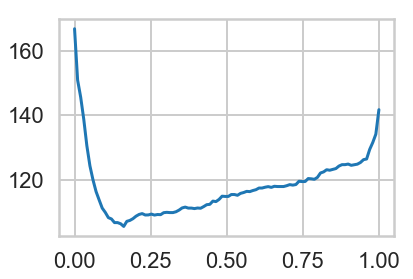

In [35]:
ts = np.linspace(0,1,100)
plt.plot(ts, [average_cost(ytest, repredict(clfgnb, t, Xtest), cost) for t in ts])

(array([890., 138.,  56.,  19.,  24.,  22.,  15.,  23.,  29., 118.]),
 array([2.32254473e-04, 1.00209028e-01, 2.00185802e-01, 3.00162576e-01,
        4.00139350e-01, 5.00116124e-01, 6.00092898e-01, 7.00069672e-01,
        8.00046446e-01, 9.00023220e-01, 9.99999994e-01]),
 <a list of 10 Patch objects>)

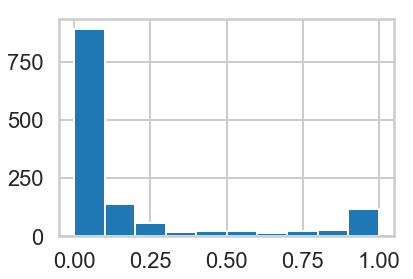

In [36]:
plt.hist(clfgnb.predict_proba(Xtest)[:,1])

Aha! At a 0.3 threshold we save more money!

We see that in this situation, where we have asymmetric costs, we do need to change the threshold at which we make our positive and negative predictions. We need to change the threshold so that we much dislike false negatives (same in the cancer case). Thus we must accept many more false positives by setting such a low threshold.

For otherwise, we let too many people slip through our hands who would have stayed with our telecom company given an incentive. But how do we pick this threshold?

### The ROC Curve

ROC curves are actually a set of classifiers, in which we move the threshold for classifying a sample as positive from 0 to 1. (In the standard scenario, where we use classifier accuracy, this threshold is implicitly set at 0.5).

We talked more about how to create a ROC curve in the accompanying lab to this one, so here we shall just repeat the ROC curve making code from there.

In [37]:
from sklearn.metrics import roc_curve, auc

In [38]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

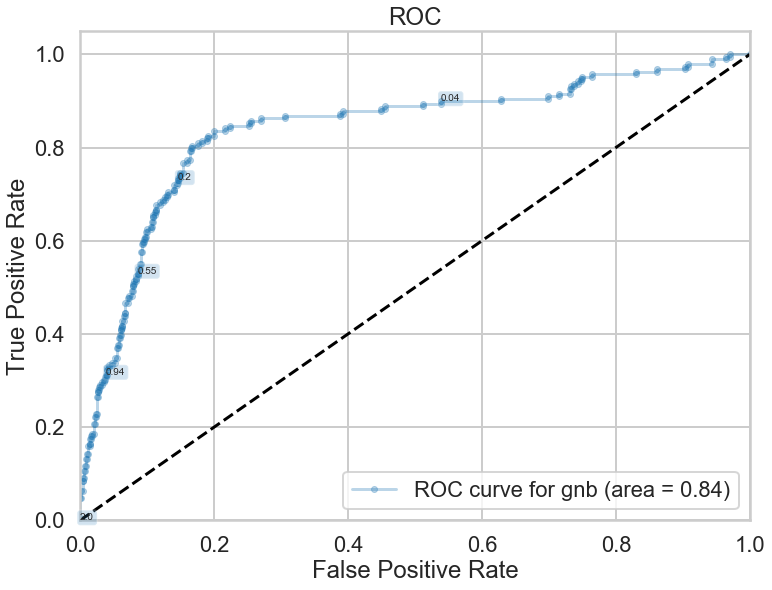

In [46]:
plt.figure(figsize=(12,9))
make_roc("gnb",clfgnb, ytest, Xtest, None, labe=50)

OK. Now that we have a ROC curve that shows us different thresholds, we need to figure how to pick the appropriate threshold from the ROC curve. But first, let us try another classifier.

## Classifier Comparison

### Decision Trees

Descision trees are very simple things we are all familiar with. If a problem is multi-dimensional, the tree goes dimension by dimension and makes cuts in the space to create a classifier.



In [40]:
from sklearn.tree import DecisionTreeClassifier

In [41]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

We train a simple decision tree classifier.

In [42]:
clfdt=DecisionTreeClassifier()
clfdt, Xtrain, ytrain, Xtest, ytest  = do_classify(clfdt, {"max_depth": list(range(1,10,1))}, dfchurn, colswewant_cont+colswewant_cat, 'Churn?', "True.", 
                                                   mode="not mask", reuse_split=reuse_split)

using reuse split
############# based on standard predict ################
Accuracy on training data: 0.97
Accuracy on test data:     0.93
[[1098   47]
 [  50  139]]
########################################################


In [43]:
confusion_matrix(ytest,clfdt.predict(Xtest))

array([[1098,   47],
       [  50,  139]])

### Compare!

YOUR TURN HERE

> Use make_roc to compare the ROC curbes. Use `labe=1` for the decision tree ROC

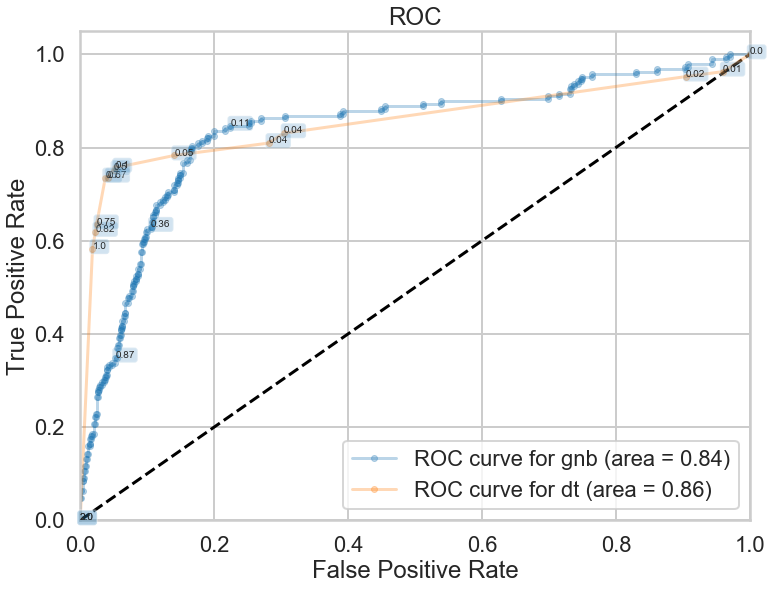

In [45]:
plt.figure(figsize=(12,9))
# your code here
ax=make_roc("gnb",clfgnb, ytest, Xtest, None, labe=60)
make_roc("dt",clfdt, ytest, Xtest, ax, labe=1)

How do we read which classifier is better from a ROC curve. The usual advice is to go to the North-West corner of a ROC curve, as that is closest to TPE=1, FPR=0. But thats not our setup here..we have this asymmetric data set. The other advice is to look at the classifier with the highest AUC. But as we can see in the image the AUC is nearly the same, but the classifiers seem to have very different performances in different parts of the graph


And then there is the question of figuring what threshold to choose as well. To answer both of these, we are going to have to turn back to cost

## Reprediction again: Now with Cost or Risk

You can use the utility or risk matrix to provide a  threshold to pick for our classifier. 

The key idea is that we want to minimize cost on our test set, so for each sample, simply pick the class which does that. 

Decision Theory is the branch of statistics that speaks to this: its the theory which tells us how to make a positive or negative prediction for a given sample.

There is a second cost or risk or loss involved in machine learning. This is the decision loss.

What do we mean by a "decision" exactly? We'll use the letter g here to indicate a decision, in both the regression and classification problems. In the classification problem, one example of a decision is the process used to choose the class of a sample, given the probability of being in that class. As another example, consider the cancer story from the previous chapter. The decision may be: ought we biopsy, or ought we not biopsy. By minimizing the estimation risk, we obtain a probability that the patient has cancer. We must mix these probabilities with "business knowledge" or "domain knowledge" to make a decision.

(As an aside, this is true in regression as well. there are really two losses there. The first one, the one equivalent to the log loss is the one where we say that at each point the prediction for y is a gaussian....the samples of this gaussian come from the bootstrap we make on the original data set...each replication leads to a new line and a distribution for the prediction at a point x. But usually in a regression we just quote the mean of this distribution at each point, the regression line E[y|x]. Why the mean? The mean comes from choosing a least squares decision loss...if we chose a L1 loss, we'd be looking at a median.)

**The cost matrix we have been using above is exactly what goes into this decision loss!!**

### Decision Theory Math

To understand this, lets follow through with a bit of math:
(you can safely skip this section if you are not interested)

We simply weigh each combinations loss by the probability that that combination can happen:

$$ R_{g}(x) = \sum_y l(y,g(x)) p(y|x)$$

That is, we calculate the **average risk** over all choices y, of making choice g for a given sample.

Then, if we want to calculate the overall risk, given all the samples in our set, we calculate:

$$R(g) = \sum_x p(x) R_{g}(x)$$

It is sufficient to minimize the risk at each point or sample to minimize the overall risk since $p(x)$ is always positive.

Consider the two class classification case. Say we make a "decision g about which class" at a sample x. Then:

$$R_g(x) = l(1, g)p(1|x) + l(0, g)p(0|x).$$

Then for the "decision" $g=1$ we have:

$$R_1(x) = l(1,1)p(1|x) + l(0,1)p(0|x),$$

and for the "decision" $g=0$ we have:

$$R_0(x) = l(1,0)p(1|x) + l(0,0)p(0|x).$$

Now, we'd choose $1$ for the sample at $x$ if:

$$R_1(x) \lt R_0(x).$$

$$ P(1|x)(l(1,1) - l(1,0)) \lt p(0|x)(l(0,0) - l(0,1))$$

This gives us a ratio `r` between the probabilities to make a prediction. We assume this is true for all samples.

So, to choose '1':

$$p(1|x) \gt r P(0|x) \implies r=\frac{l(0,1) - l(0,0)}{l(1,0) - l(1,1)} =\frac{c_{FP} - c_{TN}}{c_{FN} - c_{TP}}$$

This may also be written as:

$$P(1|x) \gt t = \frac{r}{1+r}$$.

If you assume that True positives and True negatives have no cost, and the cost of a false positive is equal to that of a false positive, then $r=1$ and the threshold is the usual intutive $t=0.5$.

In [39]:
cost

array([[   0.,  103.],
       [1000.,  553.]])

In [40]:
def rat(cost):
    return (cost[0,1] - cost[0,0])/(cost[1,0]-cost[1,1])

In [42]:
rat(cost)

0.23042505592841164

In [41]:
def c_repredict(est, c, xtest):
    r = rat(c)
    t=r/(1.+r)
    print("r=", r, "t=", t)
    probs=est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 >= t)*1
    return ypred

In [45]:
average_cost(ytest, c_repredict(clfdt, cost, Xtest), cost)

r= 0.22965440356744704 t= 0.18676337262012693


105.16754122938531

This value turns out to be only approximate, and we are better using a ROC curve or a Cost curve (below) to find minimum cost. However, it will get us in the right ballpark of the threshold we need. Note that the threshold itself depends only on costs and is independent of the classifier.

## Cost curves

The proof is always in the pudding. Why not just plot the cost/profit (per person) per threshold on a ROC like curve to see which classifier maximizes profit/minimizes cost? 

Just like in a ROC curve, we go down the sorted (by score or probability) list of samples. We one-by-one add an additional sample to our positive samples, noting down the attendant classifier's TPR and FPR and threshold. In addition to what we do for the ROC curve, we now also note down the percentage of our list of samples predicted as positive. Remember we start from the mostest positive, where the percentage labelled as positive would be minuscule, like 0.1 or so and the threshold like a 0.99 in probability or so. As we decrease the threshold, the percentage predicted to be positive clearly increases until everything is predicted positive at a threshold of 0. What we now do is, at each such additional sample/threshold (given to us by the `roc_curve` function from `sklearn`), we calculate the expected profit per person and plot it against the percentage predicted positive by that threshold to produce a profit curve. Thus, small percentages correspond to samples most likely to be positive: a percentage of 8% means the top 8% of our samples ranked by likelihood of being positive.

As in the ROC curve case, we use `sklearn`'s `roc_curve` function to return us a set of thresholds with TPRs and FPRs.

In [47]:
def percentage(tpr, fpr, priorp, priorn):
    perc = tpr*priorp + fpr*priorn
    return perc
def av_cost2(tpr, fpr, cost, priorp, priorn):
    profit = priorp*(cost[1][1]*tpr+cost[1][0]*(1.-tpr))+priorn*(cost[0][0]*(1.-fpr) +cost[0][1]*fpr)
    return profit
def plot_cost(name, clf, ytest, xtest, cost, ax=None, threshold=False, labe=200, proba=True):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    priorp=np.mean(ytest)
    priorn=1. - priorp
    ben=[]
    percs=[]
    for i,t in enumerate(thresholds):
        perc=percentage(tpr[i], fpr[i], priorp, priorn)
        ev = av_cost2(tpr[i], fpr[i], cost, priorp, priorn)
        ben.append(ev)
        percs.append(perc*100)
    ax.plot(percs, ben, '-', alpha=0.3, markersize=5, label='cost curve for %s' % name)
    if threshold:
        label_kwargs = {}
        label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
        )
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (percs[k], ben[k]), **label_kwargs)
    ax.legend(loc="lower right")
    return ax

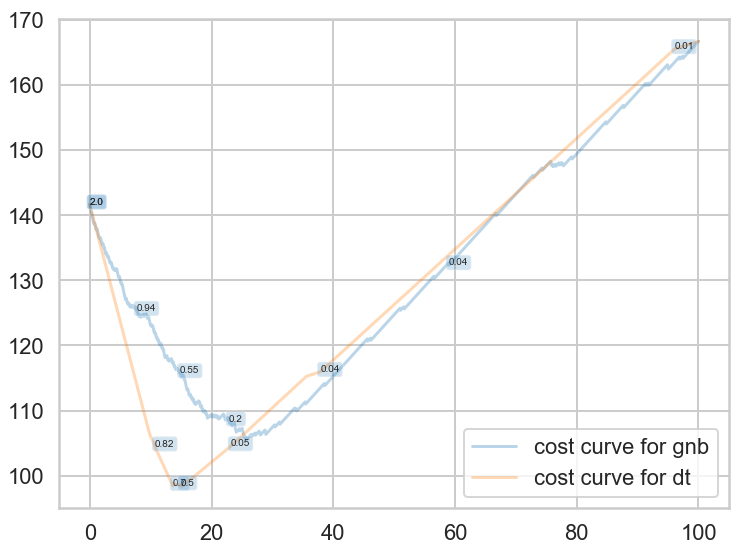

In [50]:
plt.figure(figsize=(12,9))
ax = plot_cost("gnb",clfgnb, ytest, Xtest, cost, threshold=True, labe=50);
plot_cost("dt",clfdt, ytest, Xtest, cost, ax, threshold=True, labe=2);

Note the customers on the left of this graph are most likely to churn (be positive).

This if you had a finite budget, you should be targeting them!

Finding the best classifier has a real consequence: you save money!!!


In [51]:
cost

array([[   0.,  103.],
       [1000.,  553.]])

The above graph is a snapshot of a run. One thing worth noticing is that classifiers perform differently in different regions. If you targeted only the top 20% of your users..and these are the ones most likely to churn so you should target them first, you would want to use the decision-tree classifier. And you might only get to target these top 20 given your budget. Remember that there is a cost associated with targeting predicted positives. That cost can be read of the graph above. Say we had a million customers. Now, at 10%, or 100,000 we are talking about a minimum budget of 10.3 million dollars. 

If 10-15 million is your budget, then you use the decision tree classifier on your left. If 40-60 million is your budget, roughly, you would use the gnb classifier instead.